# Pipeline Clustering Verfahren

# Inhaltsverzeichnis
1. [Daten einlesen](#introduction)
    1. [Daten aussuchen](#subparagraph1)
    2. [Daten zusammenführen](#subparagraph2)
    3. [Daten vorbereiten](#subparagraph3)
2. [K-Means](#paragraph1)
    1. [PCA davor](#subparagraph2.1)
    2. [PCA danach](#subparagraph2.2)
3. [Hierarchical Clustering](#paragraph2)
    1. [nicht reduziert](#subparagraph3.1)
    2. [reduziert](#subparagraph3.2)
4. [Gaussian Mixture Model](#paragraph3)
5. [Bayes Mixture Model](#paragraph4)

### Daten einlesen <a name="introduction"></a>

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import squareform
from sklearn.preprocessing import normalize
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# Import necessary libraries
from copy import deepcopy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

%matplotlib inline
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import itertools
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import manifold
import sklearn.datasets 
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture 

In [69]:
df = pd.read_csv("../datasets/currently_dataset/song_decades_long.csv")
df.drop(['Unnamed: 0'], inplace=True, axis = 1)

In [70]:
# df.drop(['genre1'], inplace=True, axis = 1)


In [71]:
df.head()

,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
0,"""Weird Al"" Yankovic",1980s,potato skins potato cakes hash browns and i...,potato skin potato cake hash brown and instan...,french plain enough greasy sour lumpy tough en...,Rock,antiviral pop,12745.0,2264.0
1,"""Weird Al"" Yankovic",1990s,as i walk through the valley where i harvest m...,as i walk through the valley where i harvest ...,plain perfect fancy amish amish hard amish ami...,Rock,antiviral pop,10803.0,2317.0
2,"""Weird Al"" Yankovic",2000s,jillian was her name she was sweeter than asp...,jillian wa her name she wa sweeter than aspar...,same gorgeous perfect close sweet young ripe p...,Rock,antiviral pop,4352.0,1159.0
3,"""Weird Al"" Yankovic",2010s,my mama told me when i was hatched act like a...,my mama told me when i wa hatch act like a su...,red hard sure swiss crazy little okay crazy ev...,Rock,antiviral pop,2077.0,705.0
4,*NSYNC,1990s,here we go here we go one more time eve...,here we go here we go one more time everybodi...,fine fine free right fine right fine free time...,Electronic,boy band,1786.0,345.0


In [10]:
df = df[df['Genre1'] == 'Rock']

In [21]:
df_num = df.select_dtypes(include=[np.number])

In [26]:
df

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
0,0,"""Weird Al"" Yankovic",1980s,potato skins potato cakes hash browns and i...,potato skin potato cake hash brown and instan...,french plain enough greasy sour lumpy tough en...,Rock,antiviral pop,12745.0,2264.0
1,37,"""Weird Al"" Yankovic",1990s,as i walk through the valley where i harvest m...,as i walk through the valley where i harvest ...,plain perfect fancy amish amish hard amish ami...,Rock,antiviral pop,10803.0,2317.0
2,65,"""Weird Al"" Yankovic",2000s,jillian was her name she was sweeter than asp...,jillian wa her name she wa sweeter than aspar...,same gorgeous perfect close sweet young ripe p...,Rock,antiviral pop,4352.0,1159.0
3,76,"""Weird Al"" Yankovic",2010s,my mama told me when i was hatched act like a...,my mama told me when i wa hatch act like a su...,red hard sure swiss crazy little okay crazy ev...,Rock,antiviral pop,2077.0,705.0
9,154,Adam Sandler,1990s,i'm sitting in my chair watching the tv ...,i 'm sit in my chair watch the tv it 's not e...,crazy wicked last sweet baked chair tv plenty ...,Rock,comedy,7421.0,2201.0
...,...,...,...,...,...,...,...,...,...,...
1019,13107,Yoko Ono,1970s,sisters don't blame my man too much i know ...,sister do n't blame my man too much i know he...,much gentle tender hard strong short short ash...,Rock,experimental,1810.0,455.0
1022,13140,You Am I,1990s,i know this guy if i'm the mayonnaise he's th...,i know thi guy if i 'm the mayonnais he 's th...,open whole damn open guy mayonnaise cream ride...,Rock,australian alternative rock,1787.0,566.0
1029,13194,Yusuf / Cat Stevens,1970s,[chorus: ] another saturday night and i ain't...,[ choru : ] anoth saturday night and i ai n't...,awful strange hard awful awful awful awful awf...,Rock,british folk,5082.0,912.0
1035,13277,Zebra,1980s,well you're walking on the moon but there's n...,well you 're walk on the moon but there 's no...,deep real lucky kind about about deep lucky ki...,Rock,album rock,1105.0,225.0


In [39]:
import numpy as np
df1 = df.replace(np.nan, '', regex=True)

In [44]:
df.genre1.tolist()

['antiviral pop',
 'antiviral pop',
 'antiviral pop',
 'antiviral pop',
 'comedy',
 'comedy',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'country',
 'country',
 'country',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'alternative metal',
 'album rock',
 'album rock',
 'alternative dance',
 'country rock',
 'country rock',
 'canadian pop',
 'canadian pop',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'alternative rock',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'album rock',
 'glam metal',
 'glam metal',
 'glam metal',
 'classic rock',
 'classic rock',
 'classic rock',
 'classic rock',
 'classic rock',
 'classic rock',
 'classic rock',
 'classic rock',
 'classic rock',
 'classic rock',
 'classic rock',
 'country',
 'alternative rock',
 'alternative rock',
 'adult standards',
 'album rock',
 'album rock',
 'album rock',
 'adult sta

In [12]:
data1 = df[df['Genre1'] == 'Jazz']
data2 = df[df['Genre1'] == 'Hip Hop']
data3 = df[df['Genre1'] == 'Electronic']
data4 = df[df['Genre1'] == 'Folk, World, & Country']

spezielle Daten auswählen <a name="subparagraph1"></a>

In [7]:
data1 = df[df['Genre1'] == 'Pop']
data2 = df[df['Genre1'] == 'Rock']

In [6]:
data1 = df[df['artist'] == 'Katy Perry']
data2 = df[df['artist'] == 'Olly Murs']
popartist = pd.concat([data1, data2], axis = 0)

In [7]:
data1 = df[df['artist'] == 'Eminem']
data2 = df[df['artist'] == 'ABBA']

In [13]:
data = pd.concat([data1, data2], axis = 0)

In [9]:
ohnerock = df[df.Genre1!='Rock']
ohnerock = ohnerock[ohnerock.Genre1!='Pop']

In [3]:
alternative = df[df.genre1=='alternative rock']
dance = df[df.genre1=='dance pop']
alt_danc = pd.concat([alternative, dance], axis = 0)
alt_danc

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
66,914,Blur,1990s,he's a twentieth century boy with his hands o...,he 's a twentieth centuri boy with hi hand on...,twentieth sick seamless dear other la la la tw...,Rock,alternative rock,2979.0,760.0
98,1341,Cake,1990s,well your cd collection looks shiny and costly...,well your cd collect look shini and costli . ...,shiny costly much bad much black much much muc...,Rock,alternative rock,2134.0,568.0
99,1348,Cake,2000s,adjectives on the typewriter he moves his wor...,adject on the typewrit he move hi word like a...,frenzied tight white plastic nervous tense hot...,Rock,alternative rock,2050.0,501.0
131,1738,Counting Crows,1990s,blue morning blue morning wrapped in strands ...,blue morn blue morn wrap in strand of fist an...,blue own nice slow happy safe warm sorry wrong...,Rock,alternative rock,5774.0,1118.0
132,1756,Counting Crows,2000s,they paved paradise and put up a parking lot ...,they pave paradis and put up a park lot with ...,pink swinging hot late last big yellow parking...,Rock,alternative rock,4567.0,975.0
...,...,...,...,...,...,...,...,...,...,...
917,11904,Train,2010s,knock knock who's there? two thousand and tw...,knock knock who 's there ? two thousand and t...,new dead alone good happy little right right d...,Rock,dance pop,7811.0,1242.0
978,12620,Whitney Houston,1980s,i believe the children are our are future tea...,i believ the children are our are futur teach...,future lonely easy special lonely way beauty s...,Pop,dance pop,3050.0,569.0
979,12631,Whitney Houston,1990s,this is the heart break hotel this is the hea...,thi is the heart break hotel thi is the heart...,wrong wrong heartbreak heart break hotel heart...,Pop,dance pop,6790.0,896.0
980,12654,Whitney Houston,2000s,the stars must be aligned tonight i believe t...,the star must be align tonight i believ thi h...,sane pressed many busy enough pressed possible...,Pop,dance pop,4988.0,736.0


In [9]:
data = data[data.decades=='2000s']

Daten zusammenführen <a name="subparagraph2"></a>

In [54]:
bands = pd.concat([data1, data2], axis = 0)

In [8]:
data

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types


Daten vorbereiten <a name="subparagraph3"></a>

In [60]:
tf_idf_vectorizor = TfidfVectorizer()
tf_idf = tf_idf_vectorizor.fit_transform(df.text)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

## K-Means <a name="paragraph2"></a>

PCA davor <a name="subparagraph2.1"></a>

In [49]:
from sklearn.cluster import KMeans
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

In [40]:
markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
plt.figure(figsize=(15,10))
sns.scatterplot(Y_sklearn[:, 0], Y_sklearn[:, 1],hue=prediction, style=data.genre1, markers=markers, palette=sns.color_palette("hls", len(np.unique(prediction))))
plt.title('PCA')

NameError: name 'Y_sklearn' is not defined

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'PCA')

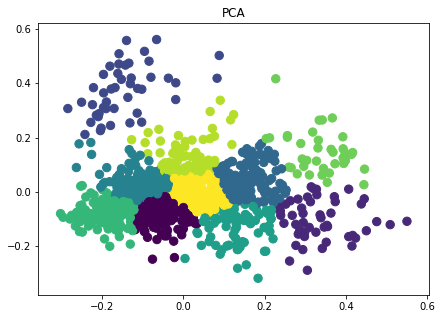

In [5]:
plt.figure(figsize=(7,5))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=70, cmap='viridis')
plt.title('PCA')
#plt.savefig('K_Means/PCA_K-Means_Lyrics.png', bbox_inches = "tight")

PCA danach <a name="subparagraph2.2"></a>

In [11]:
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(tf_idf_array)
prediction = kmeans.predict(tf_idf_array)

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

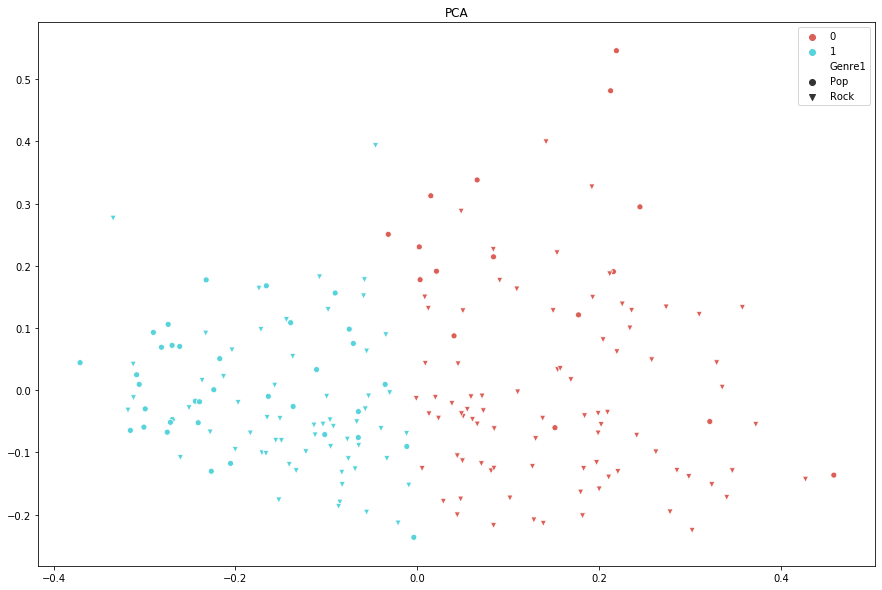

In [14]:
markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
plt.figure(figsize=(15,10))
sns.scatterplot(Y_sklearn[:, 0], Y_sklearn[:, 1],hue=prediction, style=data.Genre1, markers=markers, palette=sns.color_palette("hls", len(np.unique(prediction))))
plt.title('PCA')
plt.savefig('tsne-kmeans/K-Means_Pop_Rock_2000_PCA.png', bbox_inches = "tight")

### T-SNE danach

In [73]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer
tf_idf_vectorizor = TfidfVectorizer()
tf_idf = tf_idf_vectorizor.fit_transform(pop.text)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [23]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(tf_idf_array)
prediction = kmeans.predict(tf_idf_array)

In [24]:
X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(tf_idf_array)

In [25]:
perplexity = [50]
for p in perplexity:
    X_embedded = TSNE(n_components=2, perplexity=p, n_iter=1000,learning_rate=10, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.000s...
[t-SNE] Computed neighbors for 196 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.163461
[t-SNE] Computed conditional probabilities in 0.056s
[t-SNE] Iteration 50: error = 44.4524765, gradient norm = 0.0000000 (50 iterations in 0.154s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 44.452477
[t-SNE] Iteration 100: error = 0.5080900, gradient norm = 0.0048321 (50 iterations in 0.093s)
[t-SNE] Iteration 150: error = 0.4864828, gradient norm = 0.0004231 (50 iterations in 0.110s)
[t-SNE] Iteration 200: error = 0.4868601, gradient norm = 0.0001562 (50 iterations in 0.091s)
[t-SNE] Iteration 250: error = 0.4857822, gradient norm = 0.0004273 (50 iterations in 0.112s)
[t-SNE] Iteration 300: error = 0.4856592, gradient norm = 0.0001051 (50 iterations in 0.089s)
[t-SNE] Iteration

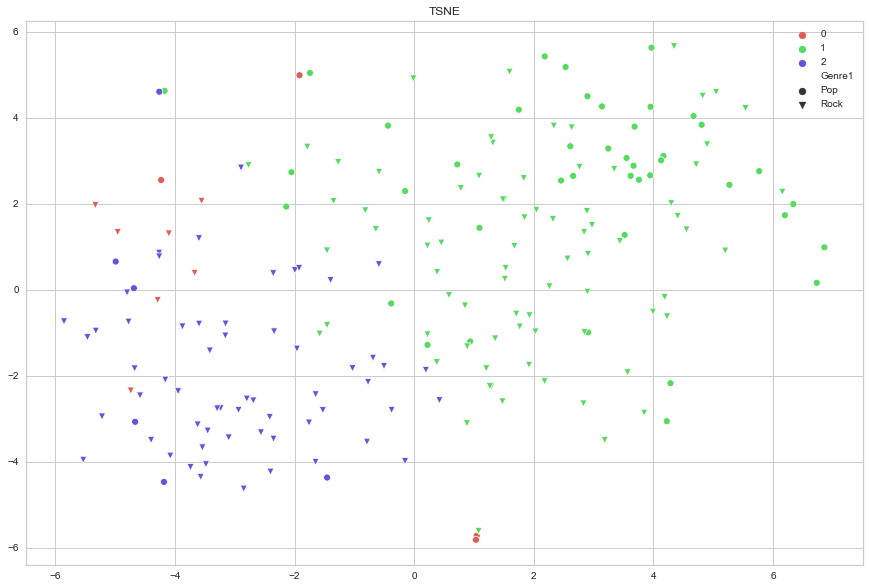

In [26]:
markers = ('o', 'v', '^', 's', 'p', '*','d', 'P', 'X')
plt.figure(figsize=(15,10))
sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=prediction, style=data.Genre1, markers=markers, palette=sns.color_palette("hls", len(np.unique(prediction))))

plt.title('TSNE')
plt.savefig('tsne-kmeans/kmeans_tsne_Pop_Rock_2000.png')

## HC <a name="paragraph2"></a>

In [72]:
pop = df[df.Genre1=='Pop']
pop

,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
7,ABBA,1970s,i'll never know why i had to go why i had to ...,i 'll never know whi i had to go whi i had to...,lousy rotten tough enough good new good new ne...,Pop,europop,8618.0,1070.0
8,ABBA,1980s,take it easy with me please touch me gently ...,take it easi with me pleas touch me gentli li...,easy slow andante soft light andante strong st...,Pop,europop,5963.0,1131.0
11,Adele,2000s,right under my feet there's air made of bricks...,right under my feet there 's air made of bric...,weak broken only only only only own dead only ...,Pop,british soul,2439.0,436.0
12,Adele,2010s,[verse 1] i will leave my heart at the door ...,[ vers 1 ] i will leav my heart at the door i...,scared scared pre chorus wrong last sure only ...,Pop,british soul,6832.0,793.0
18,Air Supply,1980s,we shared such a special love it seem to have...,we share such a special love it seem to have ...,special mejust future sure low sure love end d...,Pop,adult standards,2208.0,414.0
...,...,...,...,...,...,...,...,...,...
974,Wham!,1980s,last christmas i gave you my heart but the...,[ choru : ] last christma i gave you my heart...,last next special last next special shy last n...,Pop,dance rock,3027.0,643.0
978,Whitney Houston,1980s,i believe the children are our are future tea...,i believ the children are our are futur teach...,future lonely easy special lonely way beauty s...,Pop,dance pop,3050.0,569.0
979,Whitney Houston,1990s,this is the heart break hotel this is the hea...,thi is the heart break hotel thi is the heart...,wrong wrong heartbreak heart break hotel heart...,Pop,dance pop,6790.0,896.0
980,Whitney Houston,2000s,the stars must be aligned tonight i believe t...,the star must be align tonight i believ thi h...,sane pressed many busy enough pressed possible...,Pop,dance pop,4988.0,736.0


In [74]:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

nicht reduziert <a name="subparagraph3.1"></a>

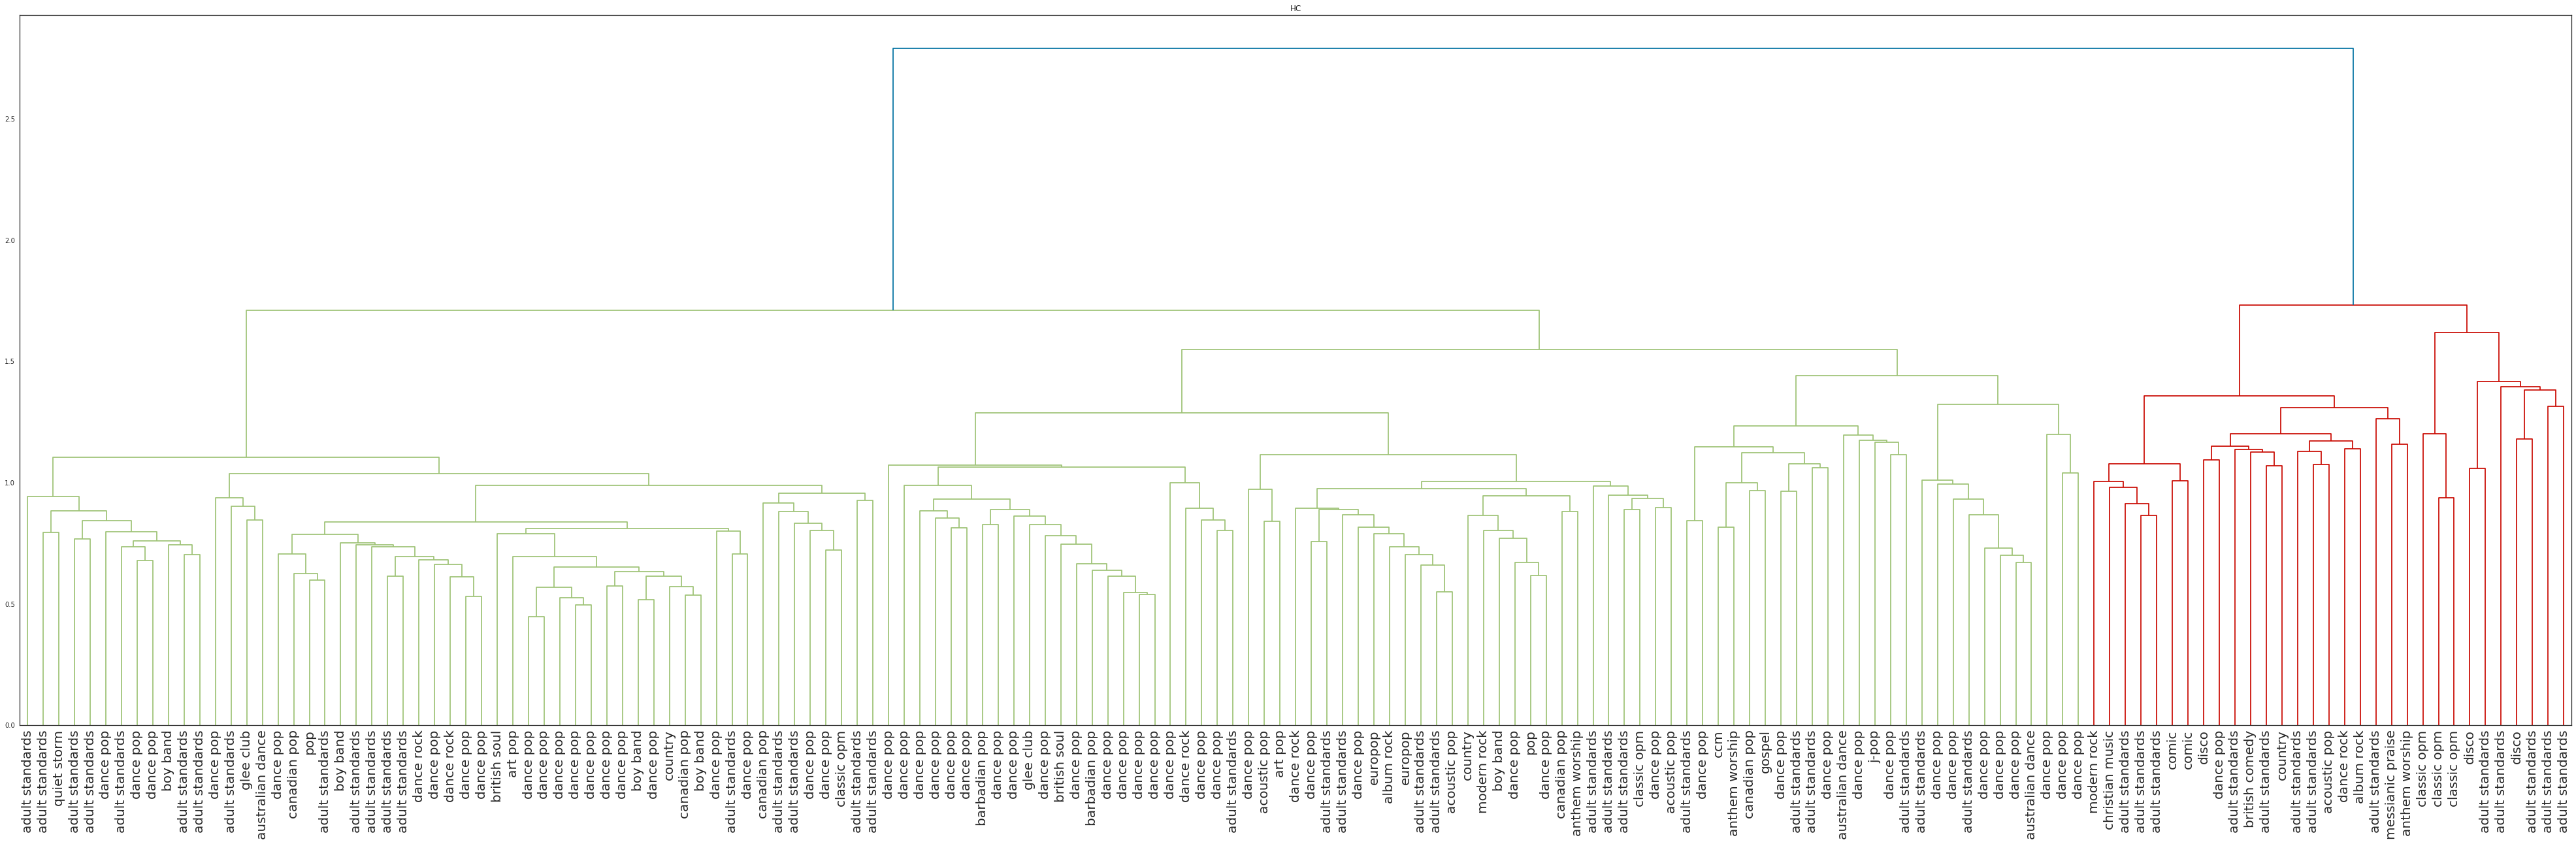

In [76]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tf_idf_array)
link_matrix = linkage_matrix(tf_idf_array.shape[0], model.children_, model.distances_)
plt.figure(figsize=(70,20))
plt.title('HC')
dendrogram(link_matrix, labels = (pop.genre1.values), leaf_font_size=20);
plt.savefig('../images/Bilder_Abschlusspräsi/HC_Pop_genre1.png', bbox_inches = "tight")

reduziert <a name="subparagraph3.2"></a>

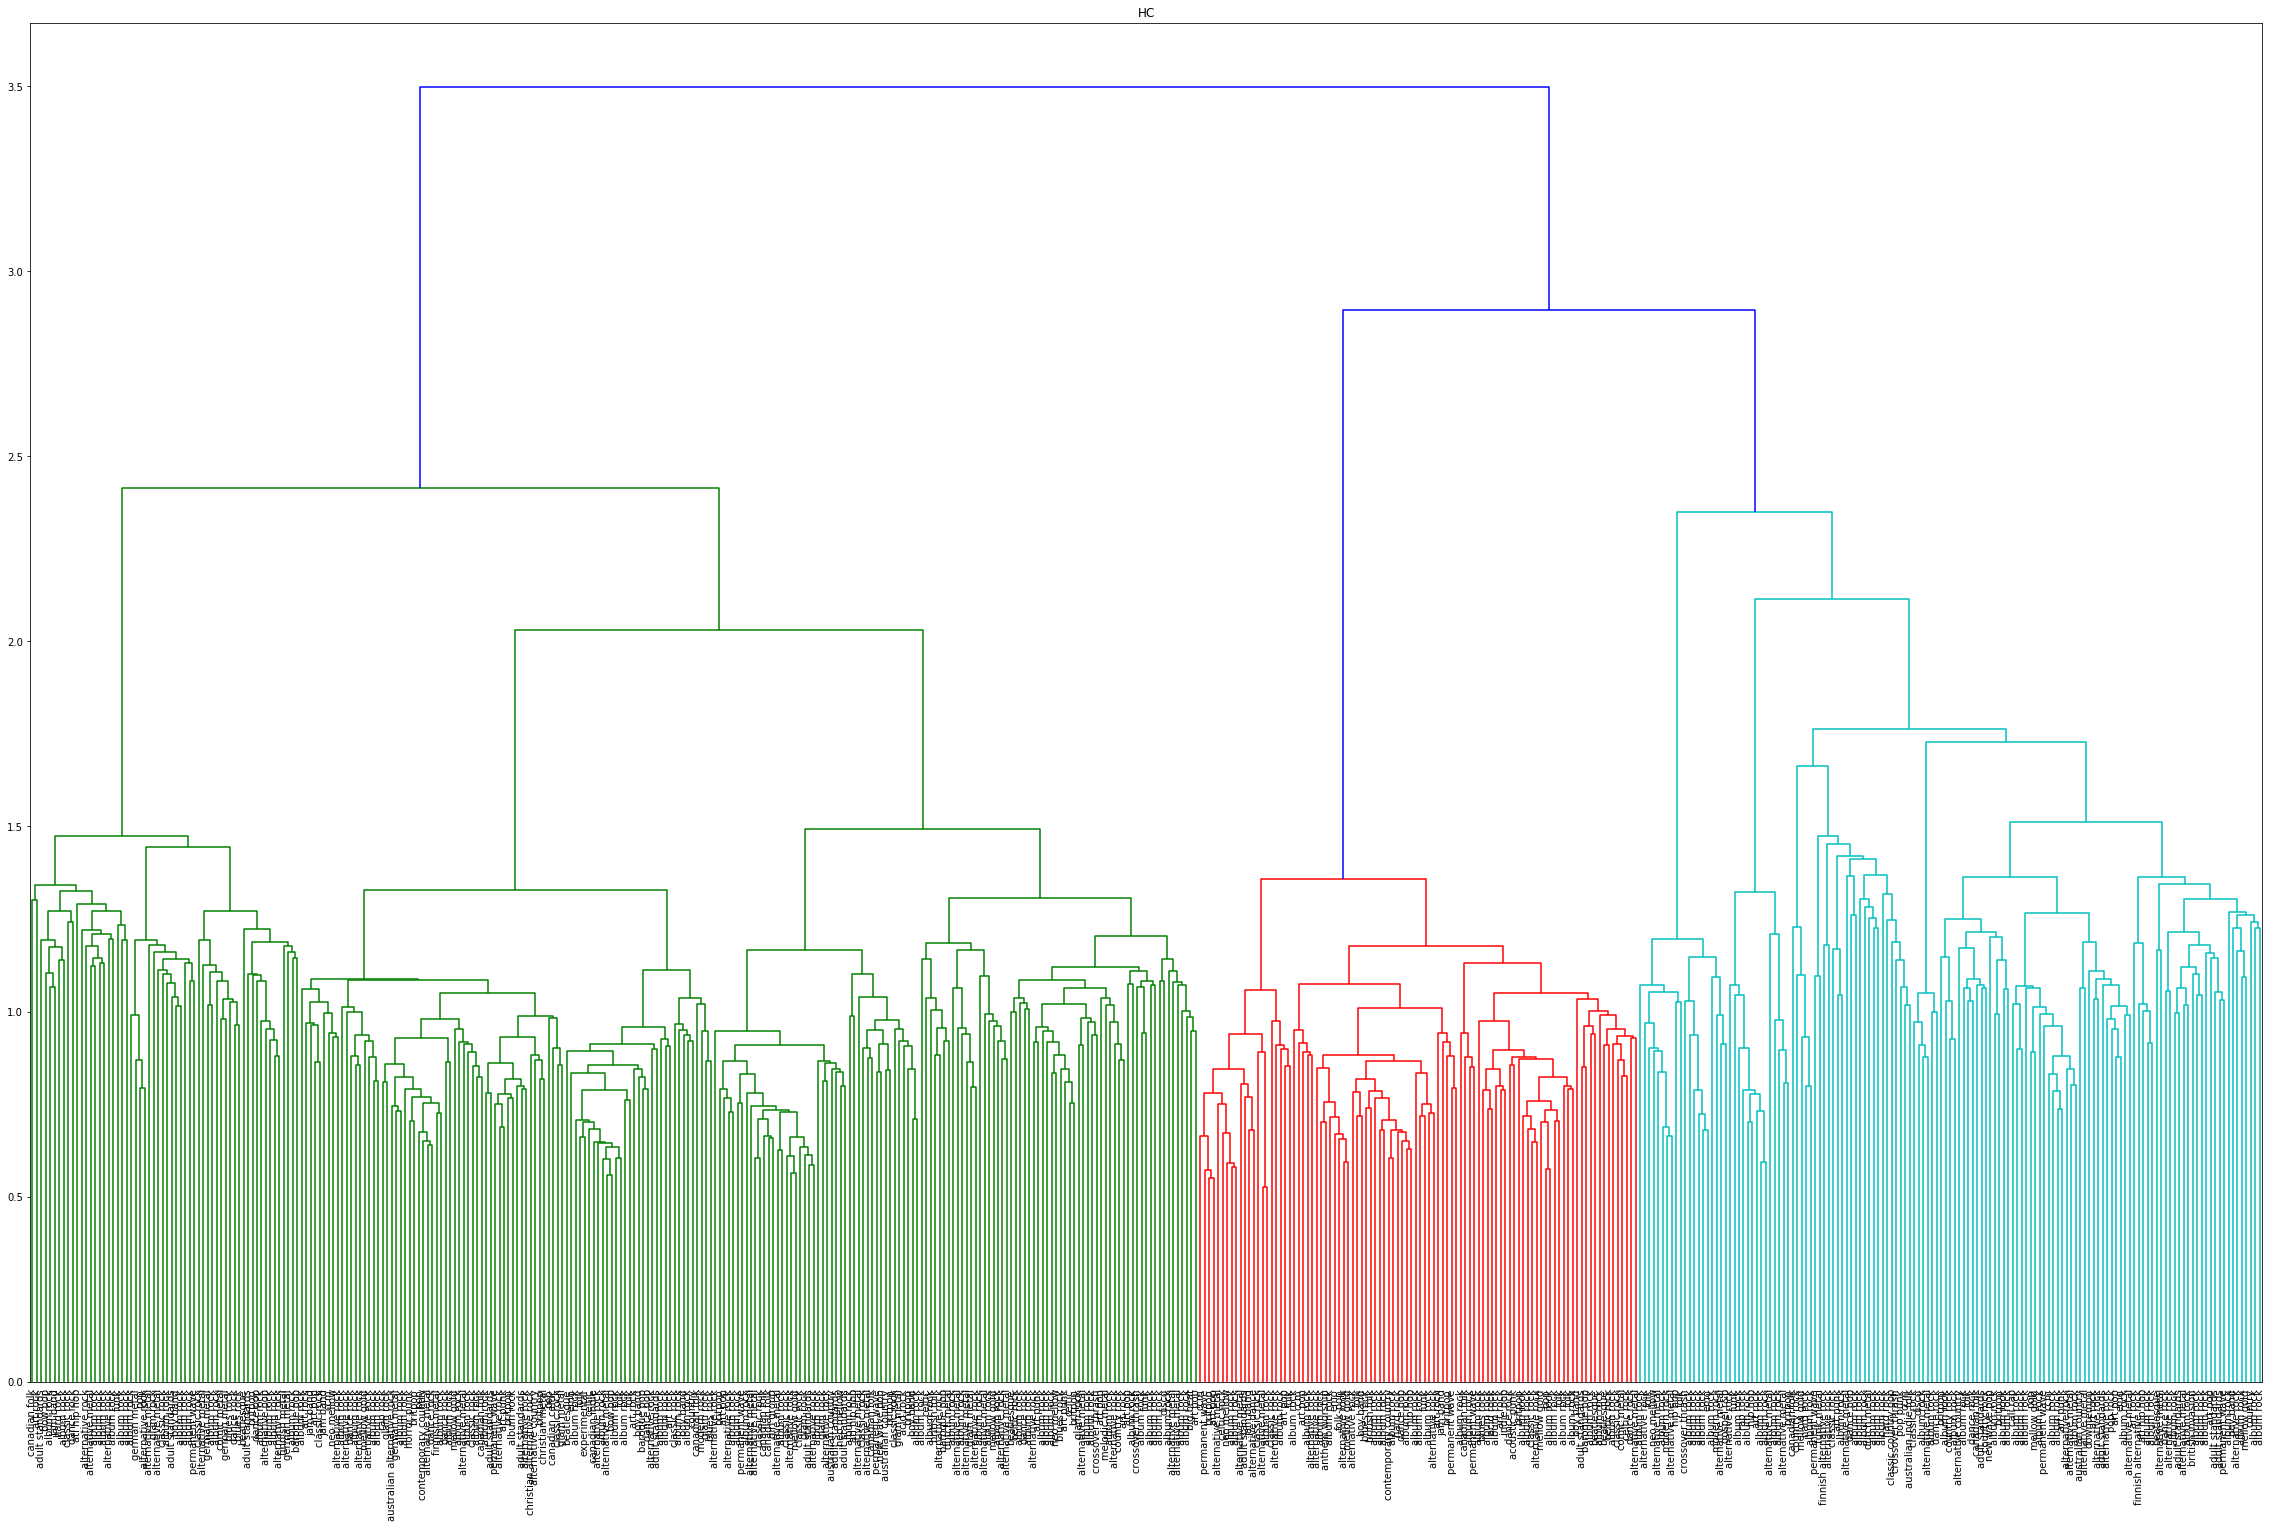

In [63]:
dfs_cleans = df1.sample(frac=0.8)
tf_idf_vectorizor = TfidfVectorizer()
tf_idf = tf_idf_vectorizor.fit_transform(dfs_cleans.text)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()


model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tf_idf_array)
link_matrix = linkage_matrix(tf_idf_array.shape[0], model.children_, model.distances_)
plt.figure(figsize=(40,25))
plt.title('HC')

h = dendrogram(link_matrix, labels = (df1.genre1.values), leaf_font_size=10, get_leaves=True);
#plt.savefig('HC_all_Genre_artist_samples.png', bbox_inches = "tight")

In [93]:
h.pop('dcoord', None)

[[0.0, 1.301488693976708, 1.301488693976708, 0.0],
 [0.0, 1.0656116987615503, 1.0656116987615503, 0.0],
 [0.0, 1.1031552963952733, 1.1031552963952733, 1.0656116987615503],
 [0.0, 1.1403793937707778, 1.1403793937707778, 0.0],
 [1.1031552963952733,
  1.1731487619614698,
  1.1731487619614698,
  1.1403793937707778],
 [0.0, 1.1926957830129263, 1.1926957830129263, 1.1731487619614698],
 [0.0, 1.243128085544721, 1.243128085544721, 0.0],
 [1.1926957830129263,
  1.2717896450551691,
  1.2717896450551691,
  1.243128085544721],
 [0.0, 1.1241677241065182, 1.1241677241065182, 0.0],
 [0.0, 1.1309584393346914, 1.1309584393346914, 0.0],
 [1.1241677241065182,
  1.144723534108312,
  1.144723534108312,
  1.1309584393346914],
 [0.0, 1.177082238168135, 1.177082238168135, 1.144723534108312],
 [0.0, 1.1956268484825017, 1.1956268484825017, 0.0],
 [1.177082238168135, 1.21068787939564, 1.21068787939564, 1.1956268484825017],
 [0.0, 1.2194370722815653, 1.2194370722815653, 1.21068787939564],
 [0.0, 1.193079218548364

In [94]:
h.keys()

dict_keys(['ivl', 'leaves', 'color_list'])

In [96]:
hc_dict= pd.DataFrame.from_dict(h)

In [116]:
from collections import Counter
hello = Counter(hc_dict[hc_dict.color_list == 'c'].ivl)

In [117]:
from operator import itemgetter
sorted(hello.items(), key=lambda k: -k[1])

[('album rock', 46),
 ('alternative metal', 13),
 ('alternative rock', 8),
 ('adult standards', 5),
 ('dance rock', 4),
 ('folk', 3),
 ('art rock', 3),
 ('britpop', 3),
 ('country rock', 3),
 ('mellow gold', 3),
 ('permanent wave', 3),
 ('modern rock', 2),
 ('hip hop', 2),
 ('crossover thrash', 2),
 ('emo', 2),
 ('canadian folk', 2),
 ('hard rock', 2),
 ('finnish alternative rock', 2),
 ('classic rock', 2),
 ('art punk', 2),
 ('ccm', 2),
 ('art pop', 2),
 ('neo mellow', 1),
 ('gospel r&b', 1),
 ('funk', 1),
 ('rap rock', 1),
 ('funk metal', 1),
 ('dance pop', 1),
 ('dutch metal', 1),
 ('classic country pop', 1),
 ('pop punk', 1),
 ('australian indie folk', 1),
 ('disco', 1),
 ('alternative country', 1),
 ('new wave pop', 1),
 ('cali rap', 1),
 ('pop', 1),
 ('australian country', 1),
 ('downtempo', 1),
 ('pop rock', 1),
 ('atl hip hop', 1),
 ('beatlesque', 1),
 ('british invasion', 1),
 ('boy band', 1)]

## Gaussian Mixture Model <a name="paragraph3"></a>

In [53]:
twenty = df[df.decades=='2000s']
twenty = twenty[twenty.Genre1!='Rock']
twenty = twenty[twenty.Genre1!='Pop']
twenty

,artist,decades,text,stemmed_text,POS,Genre1,number_of_tokens,number_of_types
5,*NSYNC,2000s,this is the time of year that we learn to giv...,thi is the time of year that we learn to give...,true hard alone dark true true true time year ...,Electronic,3700.0,548.0
32,Alison Krauss,2000s,tonight i waited but my heart is so cold 'ca...,tonight i wait but my heart is so cold 'caus ...,cold other loving tonight heart minute job chi...,"Folk, World, & Country",1318.0,371.0
42,Arrogant Worms,2000s,there are many wonders in the usa the cities ...,there are mani wonder in the usa the citi and...,many great successful sad sad joy heart ooze b...,"Folk, World, & Country",2879.0,801.0
119,Christy Moore,2000s,one summer evening drunk as hell i sat there ...,one summer even drunk as hell i sat there nea...,old kid other only brown fairer brown brown br...,"Folk, World, & Country",2154.0,750.0
137,Culture Club,2000s,sweet cunning eyes try to take from me you're...,sweet cun eye tri to take from me you 're too...,sweet cunning young wise fatal cold cold right...,Electronic,1740.0,324.0
...,...,...,...,...,...,...,...,...
1027,Yukmouth,2000s,[?] get stupid go dumb ya that's our click ...,[ ? ] get stupid go dumb ya that 's our click...,stupid dumb side tense light bright red throo ...,Hip Hop,2053.0,718.0
1028,Yung Joc,2000s,shh [incomprehensible] yo why?all know what ...,shh [ incomprehens ] yo whi ? all know what i...,top bad nuff different hot real top nuff rich ...,Hip Hop,4318.0,1194.0
1030,Z-Ro,2000s,from the south i got the diamonds in my mou...,from the south i got the diamond in my mouth ...,ready rear cold deep nice many enough many rea...,Hip Hop,10992.0,2210.0
1033,Zac Brown Band,2000s,you know i like my chicken fried cold beer on...,you know i like my chicken fri cold beer on a...,cold sweet pecan homemade much southern little...,"Folk, World, & Country",1582.0,399.0


In [54]:
tf_idf_vectorizor = TfidfVectorizer()
tf_idf = tf_idf_vectorizor.fit_transform(twenty.text)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

#### BIC

In [ ]:
n_components = np.arange(1, 20)
BIC = np.zeros(n_components.shape)
AIC = np.zeros(n_components.shape)

for i, n in enumerate(n_components):
    clf = GaussianMixture(n_components=n,
              covariance_type='tied')
    clf.fit(tf_idf_array)

    AIC[i] = clf.aic(tf_idf_array)
    BIC[i] = clf.bic(tf_idf_array)

plt.figure(figsize=(15,15))
plt.plot(n_components, AIC, label='AIC')
plt.plot(n_components, BIC, label='BIC')
plt.legend(loc=0)
plt.xlabel('n_components')
plt.ylabel('AIC / BIC')
plt.savefig('GMM_BIC_4Genre_tied')

In [17]:
def compute_PCA(text):
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(text)
    return Y

#### hard clustering

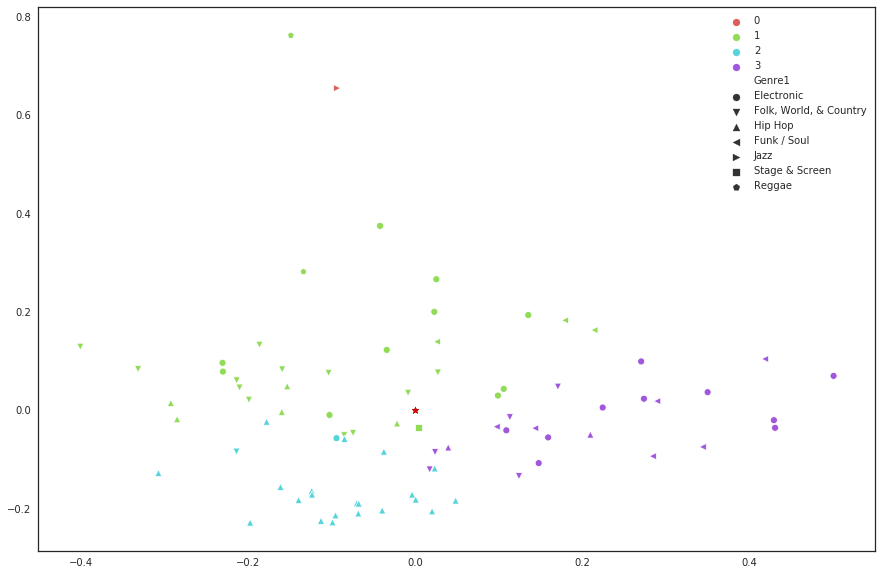

In [55]:
gmm = GaussianMixture(n_components=4, n_init=10, covariance_type='spherical').fit(tf_idf_array)
prediction = gmm.predict(tf_idf_array)
Y = compute_PCA(tf_idf_array)
plt.figure(figsize=(15,10))

# detect anomalies
densities = gmm.score_samples(tf_idf_array)
density_threshold = np.percentile(densities, 4)
anomalies = tf_idf_array[densities < density_threshold]

markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
sns.scatterplot(Y[:, 0], Y[:, 1],hue=prediction, style=twenty.Genre1, markers=markers,palette=sns.color_palette("hls", len(np.unique(prediction))))
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
# plt.savefig('GMM_images/gmm_altdanc_diag_POS+types')

In [24]:
print(gmm.means_)
print('\n')
print(gmm.covariances_)

[[0.00041298 0.00088314 0.00049773 ... 0.00017537 0.0002601  0.00015398]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


[1.82025728e-05 1.00000000e-06 1.00000000e-06 1.00000000e-06]


#### soft clustering

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.000s...
[t-SNE] Computed neighbors for 80 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 0.310925
[t-SNE] Computed conditional probabilities in 0.032s
[t-SNE] Iteration 50: error = 34.0672989, gradient norm = 0.0000091 (50 iterations in 0.144s)
[t-SNE] Iteration 100: error = 34.0672989, gradient norm = 0.0000000 (50 iterations in 0.111s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 34.067299
[t-SNE] Iteration 150: error = 0.1148442, gradient norm = 0.0084147 (50 iterations in 0.044s)
[t-SNE] Iteration 200: error = 0.0920043, gradient norm = 0.0005805 (50 iterations in 0.048s)
[t-SNE] Iteration 250: error = 0.0919777, gradient norm = 0.0000800 (50 iterations in 0.048s)
[t-SNE] Iteration 300: error = 0.0919

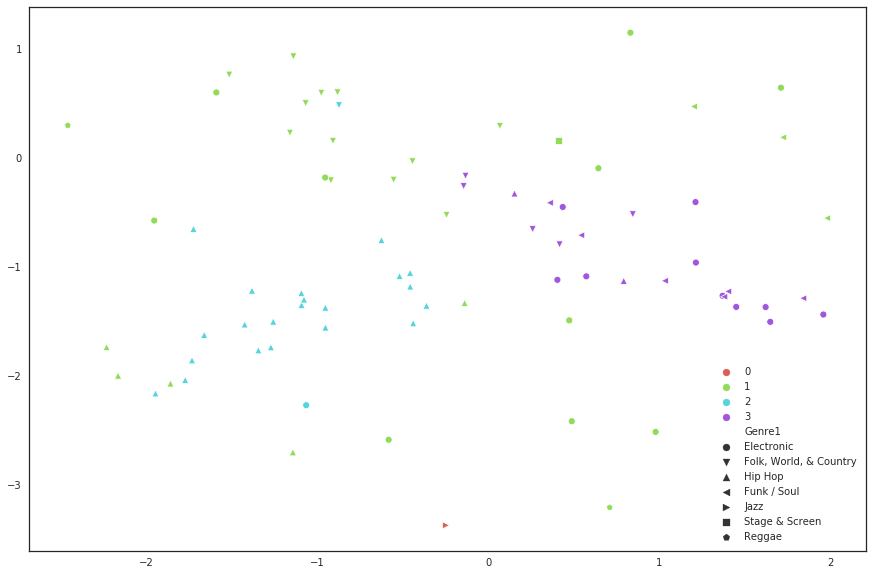

In [57]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer

probs = gmm.predict_proba(tf_idf_array)
print(probs[:5])
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.figure(figsize=(15,10))

X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(tf_idf_array)
Y = TSNE(n_components=2, perplexity=50, n_iter=1000,learning_rate=10, verbose=2).fit_transform(X_reduced)

sns.set_style("white")
sns.scatterplot(Y[:, 0], Y[:, 1],hue=prediction,markers=markers, style=twenty.Genre1,palette=sns.color_palette("hls", len(np.unique(prediction))))
plt.savefig('../images/Bilder_Abschlusspräsi/gmm_twenties_soft_spherical')

In [34]:
d = {'artist': twenty.artist, 'genre': twenty.Genre1, 'decade':twenty.decades}
dat = pd.DataFrame(data=d)
dat = dat.reset_index()
p = pd.DataFrame(data=probs)
probabilities = dat.join(p, how='outer')
probabilities.drop('index', axis=1, inplace=True)
probabilities.columns = ['artist', 'genre', 'decade', '0','1','2','3']
# pr = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('0','3')!= 0.0]]
pr = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('0')]!= 1.0]
pr = pr[pr.iloc[:, pr.columns.get_loc('0')]!= 0.0]
pro = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('1')]!= 1.0]
pro = pro[pro.iloc[:, pro.columns.get_loc('1')]!= 0.0]
prob = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('2')]!= 1.0]
prob = prob[prob.iloc[:, prob.columns.get_loc('2')]!= 0.0]
proba = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('3')]!= 1.0]
proba = proba[proba.iloc[:, proba.columns.get_loc('3')]!= 0.0]
# probab = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('4')]!= 1.0]
# probab = probab[probab.iloc[:, probab.columns.get_loc('3')]!= 0.0]
probability = pd.concat([pr, pro, prob, proba])
probability

,artist,genre,decade,0,1,2,3
54,Fall Out Boy,Rock,2000s,0.0,1.328060e-127,1.000000e+00,0.000000e+00
91,Jackson Browne,Rock,2000s,0.0,1.605886e-175,1.000000e+00,0.000000e+00
145,Ms. Lauryn Hill,Hip Hop,2000s,0.0,3.265538e-302,1.000000e+00,0.000000e+00
156,Nine Inch Nails,Electronic,2000s,0.0,9.129822e-24,1.000000e+00,0.000000e+00
191,Reba McEntire,"Folk, World, & Country",2000s,0.0,1.819207e-110,1.000000e+00,0.000000e+00
195,Robbie Williams,Pop,2000s,0.0,1.787604e-162,1.000000e+00,0.000000e+00
222,The Rolling Stones,Rock,2000s,0.0,3.334479e-200,1.000000e+00,0.000000e+00
229,Tiffany,Rock,2000s,0.0,8.046507e-309,1.000000e+00,0.000000e+00
250,Weezer,Rock,2000s,0.0,1.909938e-32,1.000000e+00,0.000000e+00
29,Culture Club,Electronic,2000s,0.0,0.000000e+00,3.973914e-230,1.000000e+00


In [36]:
probability = probability[probability.genre!='Rock']
probability = probability[probability.genre!='Pop']
probability

,artist,genre,decade,0,1,2,3
145,Ms. Lauryn Hill,Hip Hop,2000s,0.0,3.265538e-302,1.000000e+00,0.000000e+00
156,Nine Inch Nails,Electronic,2000s,0.0,9.129822e-24,1.000000e+00,0.000000e+00
191,Reba McEntire,"Folk, World, & Country",2000s,0.0,1.819207e-110,1.000000e+00,0.000000e+00
29,Culture Club,Electronic,2000s,0.0,0.000000e+00,3.973914e-230,1.000000e+00
73,Hank Williams,"Folk, World, & Country",2000s,0.0,0.000000e+00,1.994558e-218,1.000000e+00
88,Insane Clown Posse,Hip Hop,2000s,0.0,0.000000e+00,7.066848e-280,1.000000e+00
183,Q-Tip,Hip Hop,2000s,0.0,0.000000e+00,1.780805e-214,1.000000e+00
230,Tim McGraw,"Folk, World, & Country",2000s,0.0,1.000000e+00,4.653551e-288,0.000000e+00
32,David Guetta,Electronic,2000s,0.0,0.000000e+00,1.000000e+00,3.953938e-288
35,Dolly Parton,"Folk, World, & Country",2000s,0.0,0.000000e+00,1.000000e+00,8.576813e-188


In [35]:
probabilities

,artist,genre,decade,0,1,2,3
0,"""Weird Al"" Yankovic",Rock,2000s,0.0,0.0,0.0,1.0
1,*NSYNC,Electronic,2000s,0.0,1.0,0.0,0.0
2,Adam Sandler,Rock,2000s,0.0,0.0,0.0,1.0
3,Adele,Pop,2000s,0.0,1.0,0.0,0.0
4,Aerosmith,Rock,2000s,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
271,Yung Joc,Hip Hop,2000s,1.0,0.0,0.0,0.0
272,Z-Ro,Hip Hop,2000s,1.0,0.0,0.0,0.0
273,Zac Brown Band,"Folk, World, & Country",2000s,0.0,0.0,0.0,1.0
274,Zero 7,Rock,2000s,0.0,1.0,0.0,0.0


## Bayes GMM <a name="paragraph4"></a>

https://www.geeksforgeeks.org/ml-variational-bayesian-inference-for-gaussian-mixture/

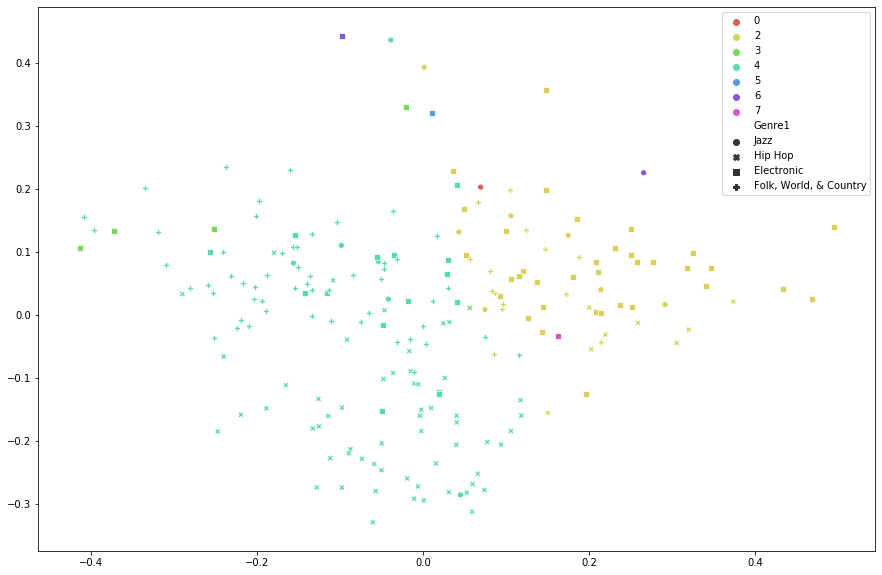

In [16]:
# Building and training the model 
bgmm = BayesianGaussianMixture(n_components=8, n_init=10, covariance_type ='diag').fit(tf_idf_array) 
Y = compute_PCA(tf_idf_array)

# Storing the labels 
prediction = bgmm.predict(tf_idf_array) 
# print((prediction)) 
plt.figure(figsize=(15,10))
sns.scatterplot(Y[:, 0], Y[:, 1],hue=prediction, style=data.Genre1, palette=sns.color_palette("hls", len(np.unique(prediction))))
# plt.savefig('GMM_images/bgmm_popartist_diag')

In [18]:
 np.round(bgmm.weights_, 2)

array([0.01, 0.  , 0.31, 0.03, 0.63, 0.01, 0.01, 0.  ])

In [62]:
bgmm.converged_

True

#### Kernel PCA

In [6]:
def compute_PCA(text):
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(text)
    return Y

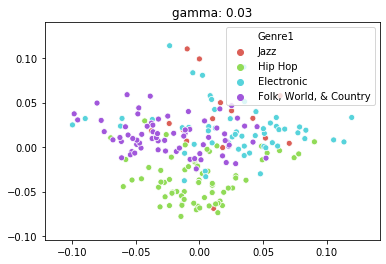

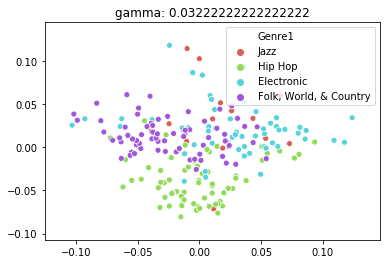

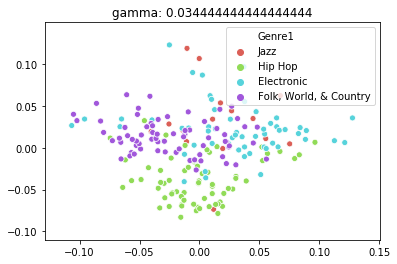

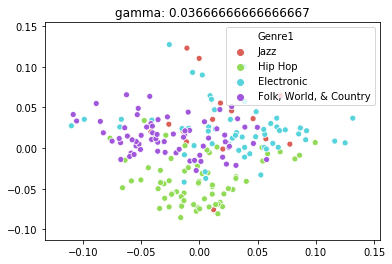

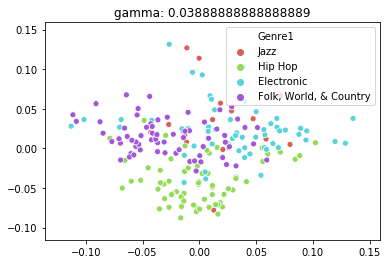

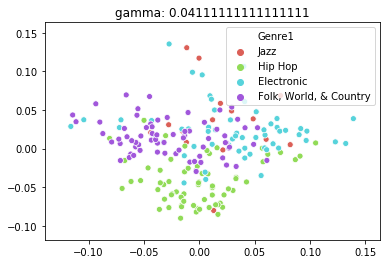

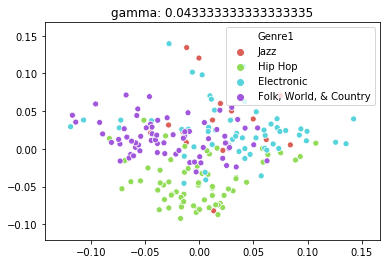

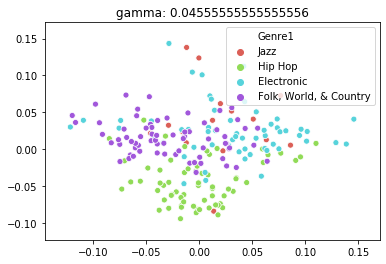

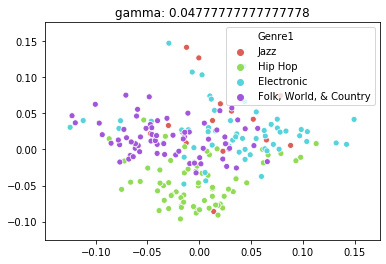

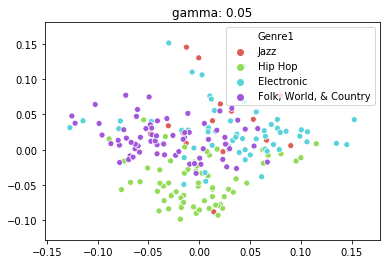

In [19]:
from sklearn.decomposition import KernelPCA
kpca_gamma = np.linspace(0.03, 0.05, 10)
for k in kpca_gamma:
    plt.clf()
    rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=k)
    Y = rbf_pca.fit_transform(tf_idf_array)
    sns.scatterplot(Y[:, 0], Y[:, 1],hue=data.Genre1, palette=sns.color_palette("hls", len(np.unique(data.Genre1))))
    plt.title('gamma: '+ str(k))
    plt.show()

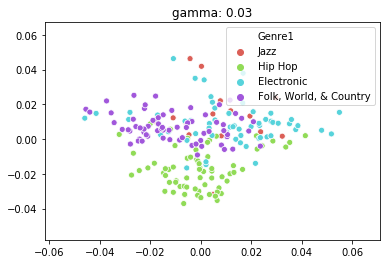

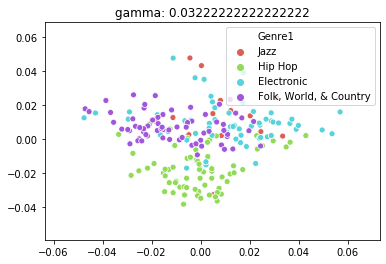

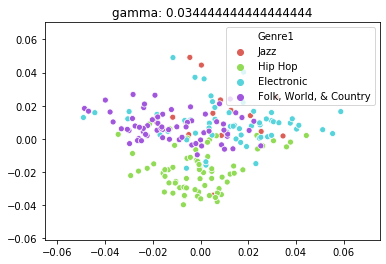

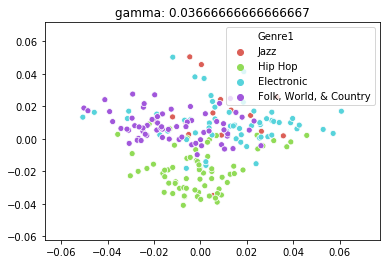

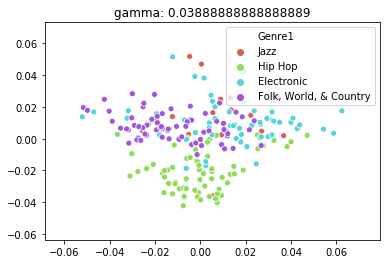

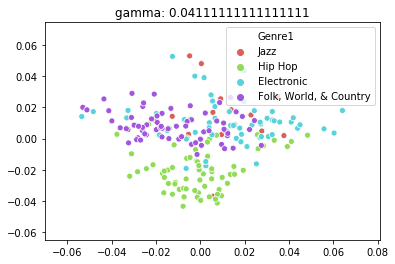

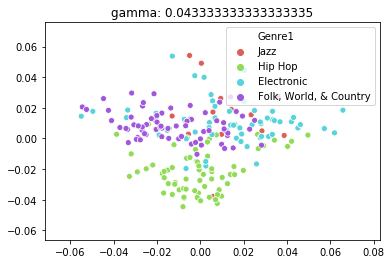

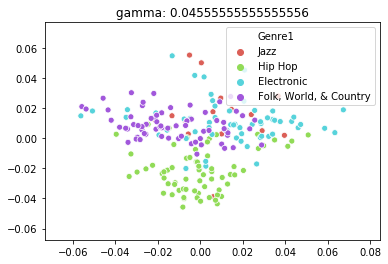

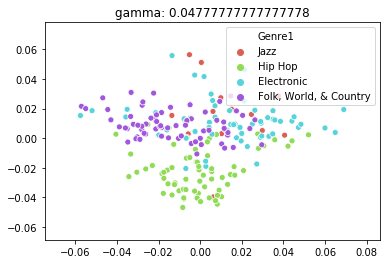

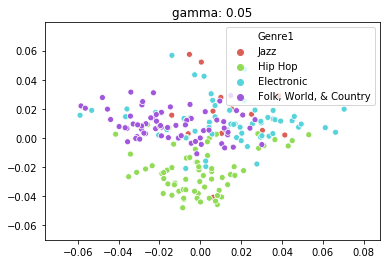

In [20]:
for k in kpca_gamma:
    plt.clf()
    sigmoid_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=k)
    Y = sigmoid_pca.fit_transform(tf_idf_array)
    sns.scatterplot(Y[:, 0], Y[:, 1],hue=data.Genre1, palette=sns.color_palette("hls", len(np.unique(data.Genre1))))
    plt.title('gamma: '+str(k))
    plt.show()

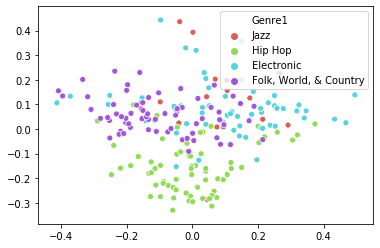

In [21]:
Y = compute_PCA(tf_idf_array)
sns.scatterplot(Y[:, 0], Y[:, 1],hue=data.Genre1, palette=sns.color_palette("hls", len(np.unique(data.Genre1))))

#### Locally Linear Embedding

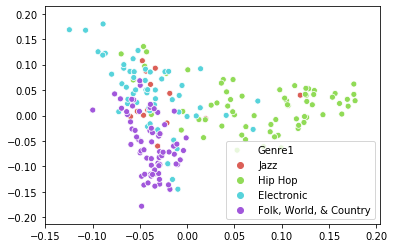

In [23]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=50)
Y = lle.fit_transform(tf_idf_array)
sns.scatterplot(Y[:, 0], Y[:, 1],hue=data.Genre1, palette=sns.color_palette("hls", len(np.unique(data.Genre1))))